In [1]:
import sys
sys.path.append("../..")
from community_accessibility import *

set_plot_formatting()

In [2]:
output_filename = '../output/median_ground_motion_comparison_results.h5'

In [3]:
case = 'baseline'
i_rup = 0

In [4]:
  with h5py.File(output_filename, 'r') as hf:

    cases = ast.literal_eval(hf['Results'].attrs.__getitem__('contents'))
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/Hazard_and_Vulnerability_Sampling/ground_motion_map_indices'
    gm_map_indices = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/community_damage'
    community_damage = hf[dset][:]
    damage_parameters = hf[dset].attrs.__getitem__('damage_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_downtime'
    community_downtime = hf[dset][:]
    downtime_parameters = hf[dset].attrs.__getitem__('downtime_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_recovery'
    community_recovery = 100 * hf[dset][:]
    time = hf[dset].attrs.__getitem__('time')
    recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
    occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_durations'
    cordon_durations = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_duration_adjacency'
    cordon_duration_adjacency = hf[dset][:]
    
    key = '/Results/'+\
          '/CommunityDamage_' + str(i_damage) + \
          '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
          '/CordonLogistics/Cordons_' + str(i_cordons) + \
          '/CordonNetwork/' + 'cordon_locations'
    cordon_locations = pd.read_hdf(output_filename, key=key)
    dset = hf[key]
    cordon_map = eval(dset.attrs.__getitem__('cordon_map'))
    cordon_map = gpd.GeoDataFrame.from_features(cordon_map)
    cordon_map.set_index('id', drop=True, inplace=True)
    cordon_map.crs = {'init': 'epsg:4326'}

C:\Users\ahul697\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Number of sims plotted: 28


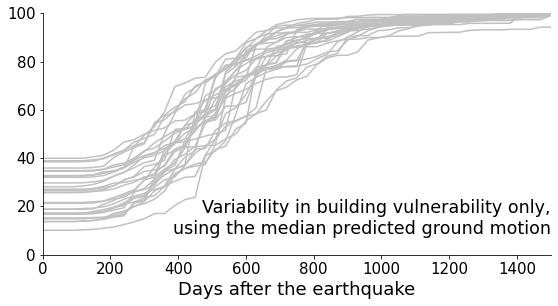

In [7]:
rec_idx = np.where(recovery_labels == 'total_downtime')[0]
occ_idx = np.where(occupancy_labels == 'Commercial Office')[0]
rup_idx = i_rup

community_recovery = community_recovery
[_,_,_,_,n_sims] = community_recovery.shape
sims_idx = range(1, n_sims, 36)
print('Number of sims plotted: ' + str(len(sims_idx)))


[fig,ax] = plt.subplots(1,1,figsize=(8,4.5))
_ = plt.plot(time,community_recovery[:,rup_idx,occ_idx,rec_idx,sims_idx], color='silver', zorder=2)

_ = plt.xlim([0,1500])
_ = plt.ylim([0,100])
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['top'].set_visible(False)

_ = plt.xlabel('Days after the earthquake')
_ = plt.tight_layout()

_ = ax.annotate('Variability in building vulnerability only,\nusing the median predicted ground motion', [1500, 15],
               ha='right', va='center', fontsize=17.5)

filename = 'summary_statistics_given_median_ground_motion'
plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('figures_png/'+filename+'.png', dpi=300, bbox_inches='tight', pad_inches=0.1)